<a href="https://colab.research.google.com/github/mateusokp/Deep-Learning/blob/main/Copy_of_E07_Recomenda%C3%A7%C3%A3o_usando_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E07 Sistema de Recomendação usando Word2Vec

Neste exercício você irá desenvolver um sistema de recomendação usando _embeddings_ criados com Word2Vec. A partir de uma base de dados de _e-commerce_ onde estão registradas as compras de um site de vendas pela internet, vamos avaliar quais mercadorias foram compradas juntamente a quais outras mercadorias. O pressuposto aqui é que quando o cliente realiza uma compra online, ele possui um interesse temático em mente e acaba comprando itens que se correlacionam de alguma forma. Ainda que em alguns casos possam ser incluídos itens menos relacionados, em sua vasta maioria assumimos que as compras seguem algum tipo de correlação entre si. Por exemplo, um cliente pode estar fazendo compras para organizar uma festa infantil ou uma viagem, e de acordo com esse interesse, acaba comprando itens relacionados a essas atividades.

Sendo assim, neste exercício, nosso interesse estará em tentar criar um embedding usando o algoritmo Word2Vec, usando como contexto de vizinhança a sequência de produtos comprados por um mesmo cliente em uma específica nota fiscal. Cada ordem de compra (carrinho de compras) vai conter uma lista de produtos, e os códigos de identificação destes produtos serão nossas "palavras", sendo que a sequência de produtos comprados formam as "frases" para nosso treinamento.

Como neste exercício usaremos a biblioteca _gensim_, você perceberá que a parte mais trabalhosa do exercício estará na preparação dos dados, já que a ferramenta que cria o _embedding_ já estará pronta para uso. Então nesse exercício, você ficara encarregado da preparação dos dados.

Para resolver o exercício, siga os passos, lendo as instruções e comentários, um a um, e preenchendo código onde for requisitado.

## Passo 1: Baixar Dados

Aqui usaremos uma planilha do Microsoft Excel com dados de compras de usuários em um sistema de varejo. O nome do arquivo é `retail.xlsx`.

In [ ]:
# O comando abaixo baixa o arquivo correspondente a essa planilha
# do Excel para o computador remoto do Google Colab.

!gdown https://drive.google.com/uc?id=1NK-2z0l-qTplDJJ2SHpTVBGRP3zWAK-n

Downloading...
From: https://drive.google.com/uc?id=1NK-2z0l-qTplDJJ2SHpTVBGRP3zWAK-n
To: /content/retail.xlsx
100% 23.7M/23.7M [00:00<00:00, 89.3MB/s]


Usaremos a biblioteca `pandas` para fazer a leitura dos dados

In [ ]:
import pandas as pd

Aqui fazemos a leitura dos dados para um objeto `DataFrame` do `pandas`.

In [ ]:
# Esta linha de código pode demorar cerca de 1 min para rodar
df = pd.read_excel('retail.xlsx')

Agora podemos observar os dados para entender como estão organizados.

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


A tabela acima mostra a estrutura da planilha. Podemos observar os campos:

- **InvoiceNo**: Este é um identificador único para cada compra.
- **StockCode**: Identificador único para cada produto.
- **Description**: Descrição do produto.
- **Quantidade**: Quantidade daquele produto, naquela compra.
- **InvoiceDate**: Dia e hora da compra.
- **CustomerID**: Identificador único do cliente.

In [ ]:
df.shape

(541909, 8)

Acima vemos que essa base de dados possui 541.909 registros. Cada registro representa uma linha, ou seja, um produto comprado (cuja quantidade pode ser maior que 1). Diferentes linhas podem representar diferentes itens de uma mesma compra.

## Passo 2: Remoção de Dados Nulos

Neste passo vamos remover da base de dados os dados relativos a compras de produtos onde algum dos dados de interesse estejam faltando.

Começamos observando a quantidade de dados nulos

In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Acima podemos observar há 1.454 registros sem a descrição do produto, e 135.080 registros sem a identificação do cliente comprador.

No código abaixo você deve remover todos os registros onde aparece pelo menos um dos campos nulos. Para entender como fazer isso, veja esse trecho da videoaula sobre pandas (especificamente a partir de 19m41s no vídeo, até mais ou menos 21m).



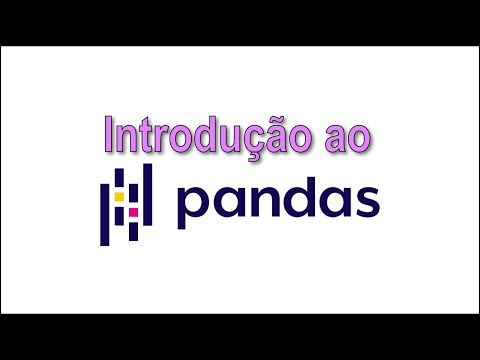

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('usmbTUx9zdY', start=1181)

In [ ]:
# Insira aqui seu código para remover os dados nulos.
# Ao final do código, a variável df deve ser um DataFrame
# do pandas contendo apenas os registros onde nenhuma
# coluna é nula. O resultado deve ser sobrescrito na
# na própria variável df. Há duas formas de fazer isso
# no pandas
#
#  Opção 1 Usando inplace: df.função(argumentos, inplace=True)
#  Opção 2 Usando atribuição: df = df.função(argumentos)
df.dropna(inplace=True)
# SEU CÓDIGO AQUI!

In [ ]:
# Verifica novamente. Dessa vez os valores
# da soma devem estar zerados para todas
# colunas.

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Passo 3: Dicionário de Produtos

Agora vamos preparar um dicionário de códigos e respectivas descrições dos produtos. Esse dicionário servirá para que nós, humanos, possamos inspecionar o resultado de nossas operações no _embedding_, já que o _embedding_ vai ser treinado com base nos códigos dos produtos. Como os códigos não permitem inspeção intuitiva da natureza de cada produto, vamos precisar desse dicionário para entender qual é a descrição do produto correspondente a cada código.

### Passo 3.1: Conversão dos Códigos para Strings

Começamos convertendo os códigos de produto (coluna **StockCode**) para string, para usar como "palavras" no treinamento de um modelo word2vec no `gensim` mais tarde.

Para fazer isso você pode usar o método `.astype(tipo)` do pandas. Com esse comando, você consegue converter uma coluna específica do DataFrame para o tipo de dado que quiser. Por exemplo, se tivéssemos um DataFrame `d` com uma coluna chamada `idade` no formato `int` e se quiséssemos converter para o formato `float`, bastaria executar o comando:

`# Converte idade para float`

`d['idade'] = d['idade'].astype(float)`

No nosso caso, queremos transformar o campo `StockCode` do DataFrame `df` para o formato string (`str`). Após a alteração, os elementos da coluna `StockCode` de `df` deverão ser strings.


In [ ]:
# Escreva abaixo seu código para converter os códigos
# de produtos (campo 'StockCode') para o formato string
# no DataFrame df.
df['StockCode'] = df['StockCode'].astype(str)
# SEU CÓDIGO AQUI!

### Passo 3.2

Agora criaremos um novo _DataFrame_, de nome `products`. Selecionaremos apenas as colunas `StockCode` e `Description` do _DataFrame_ original, `df`.

Para entender como selecionar colunas específicas, veja o vídeo abaixo a partir de 21m07s até 21m35s.

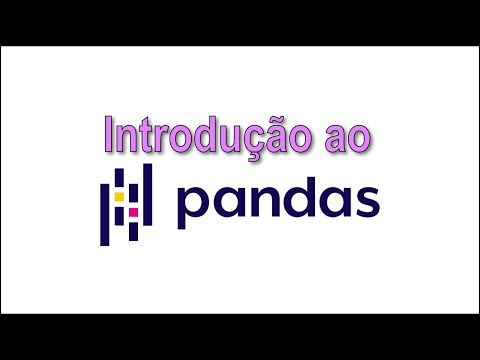

In [ ]:
YouTubeVideo('usmbTUx9zdY', start=1267)

Escreva seu código abaixo, criando o `DataFrame` de nome `products` que seleciona apenas as colunas `StockCode` e `Description`.

In [ ]:
# Escreva aqui abaixo seu código para separar apenas
# as colunas de código de produto, nome 'StockCode'
# e descrição, nome 'Description'. O novo DataFrame
# deve ser gravado na variável de nome products.
products = df[['StockCode','Description']].copy()
products
# SEU CÓDIGO AQUI!

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
...,...,...
541904,22613,PACK OF 20 SPACEBOY NAPKINS
541905,22899,CHILDREN'S APRON DOLLY GIRL
541906,23254,CHILDRENS CUTLERY DOLLY GIRL
541907,23255,CHILDRENS CUTLERY CIRCUS PARADE


### Passo 3.3 Remoção de Itens Duplicados

Obviamente muitos produtos foram comprados mais de uma vez. Em nosso dicionário de códigos e descrições, como a finalidade é simplesmente identificar a descrição que corresponde a um determinado código, então não faz sentido ter itens duplicados.

No código abaixo faça uma remoção de todas entradas onde o código do produto (coluna `StockCode`) seja duplicado.

Para entender como fazer isso, veja o vídeo abaixo a partir de 21m41s até 22m10s.

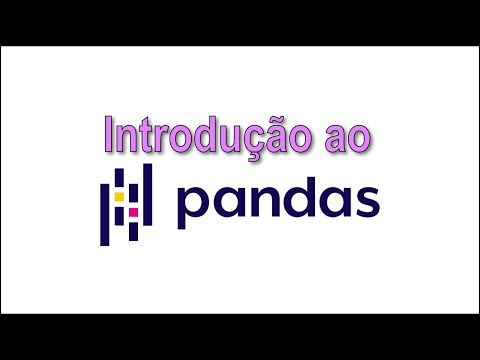

In [ ]:
YouTubeVideo('usmbTUx9zdY', start=1301)

In [ ]:
# Escreva abaixo o código para remover os itens duplicados
# do DataFrame de produtos. Ao fazer isso garanta que o nome
# do DataFrame seja o mesmo, ou seja, o resultado deve ser
# gravado na própria variável products.
products.drop_duplicates(inplace=True,subset='StockCode',keep='last')
products
# SEU CÓDIGO AQUI!

,StockCode,Description
107,84854,GIRLY PINK TOOL SET
902,21895,POTTING SHED SOW 'N' GROW SET
1985,20957,PORCELAIN HANGING BELL SMALL
2313,82615,PINK MARSHMALLOW SCARF KNITTING KIT
2457,21488,RED WHITE SCARF HOT WATER BOTTLE
...,...,...
541904,22613,PACK OF 20 SPACEBOY NAPKINS
541905,22899,CHILDREN'S APRON DOLLY GIRL
541906,23254,CHILDRENS CUTLERY DOLLY GIRL
541907,23255,CHILDRENS CUTLERY CIRCUS PARADE


### Passo 3.4 Criação do Dicionário

Agora você vai criar um dicionário nativo do Python, onde as chaves serão os códigos dos produtos (`StockCode`) e os valores serão as respectivas strings de descrição (`Description`).

Para entender como converter este DataFrame em um dicionário, assista o vídeo abaixo, a partir de 22min35s até 23min03s.

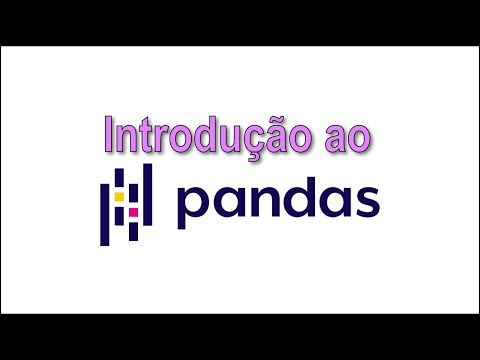

In [ ]:
YouTubeVideo('usmbTUx9zdY', start=1355)

In [ ]:
# Escreva aqui seu código para criar um dicionário do
# Python a partir do DataFrame products. O nome do
# dicionário deverá ser prodcuts_dict
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()
# SEU CÓDIGO AQUI!

In [ ]:
# Teste do dicionário: na linha de código abaixo
# consultamos um código de produto no seu dicionário.
# Se você cumpriu todos passos corretamente até
# aqui, então o resultado deve ser uma lista contendo
# uma única string, que é a descrição do produto
# correspondente àquele código.

products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

## Passo 4: Preparação dos Dados

Neste passo vamos preprarar os dados transformando o histórico de compras de cada consumidor numa espécie de "frase", onde cada "palavra" é um produto comprado.

### Passo 4.1: Contagem dos Clientes Únicos

Nesta base de dados temos o registro de cada compra de cada cliente ao longo de um ano. Isso significa que não apenas podemos ter o mesmo produto sendo comprado por diferentes clientes, mas também teremos o mesmo cliente, fazendo diferentes compras em diferentes momentos.

Para avaliar nosso sistema de forma mais justa e próxima de um uso real, vamos tentar separar dados de validação e dados de treinamento de forma que não usemos compras de um mesmo cliente nos dados de validação e nos dados de treinamento (mesmo que em momentos diferentes). Em outras palavras, vamos separar _todas as compras_ de certos clientes para treinamento e _todas as compras_ de certos outros clientes para validação, ou seja, a separação será pelo cliente que realizou a compra. Assim todas compras de um determinado cliente estarão exclusivamente nos dados de validação ou exclusivamente nos dados de treinamento, nunca em ambos. Isso servirá para que possamos avaliar se o sistema de recomendação funciona, mesmo quando treinado para clientes diferentes daqueles para os quais estamos recomendando no momento: quer dizer que podemos treinar o sistema com as compras dos clientes escolhidos para o grupo de treinamento e avaliar as recomendações num grupo de clientes que o sistema nunca viu antes.

Para fazer isso, seria interessante começar confirmando exatamente quantos clientes únicos temos nessa base de dados.

A partir do DataFrame `df` selecione a coluna `CustomerID` e usando os métodos `unique()` e a conversão `tolist()`, gere uma lista com todos os ids de clientes únicos. Essa lista deverá se chamar `customers`.

O vídeo abaixo, a partir de 23m59s até 25m16s, mostra como isso pode ser feito.

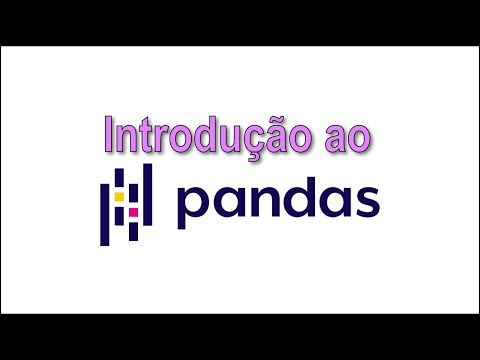

In [ ]:
YouTubeVideo('usmbTUx9zdY', start=1439)

In [ ]:
# Escreva abaixo o código que cria uma lista 
# coletando os ids da coluna CustomerID de df,
# selecionando apenas ids únicos (não recolhe
# ids repetidos). Esta lista deve ser uma lista
# nativa do Python, de nome customers.
customers = df['CustomerID'].unique().tolist()
# SEU CÓDIGO AQUI!

In [ ]:
len(customers)

4372

Se tudo deu certo até aqui, então verificamos que há exatamente 4.372 clientes na nossa base de dados. Para cada um desses clientes vamos verificar o histórico de compras, criando 4.372 sequências de compras.

### Passo 4.2: Embaralhamento dos Dados

Agora escreva código para embaralhar a ordem dos ids dos clientes na lista `customers`, usando o método `shuffle`. O resultado deve estar na própria variável `customers` (não mude o nome da variável).

In [ ]:
# No espaço abaixo, importe o módulo random
# e chame a função shuffle embaralhando os
# itens na lista customers
import random
random.shuffle(customers)
# SEU CÓDIGO AQUI!

### Passo 4.3: Separação dos Dados de Treinamento e Validação

Agora vamos separar dados de treinamento e de validação. Vamos separar 10% dos dados para validação e 90% dos dados para treinamento. Mas esses percentuais serão separados em termos de clientes. Isso significa que faremos o seguinte:

1. Definiremos uma lista de clientes de treinamento, contendo 90% dos itens da variável `customers`. Vamos chamar essa variável de `customers_train`.
2. Definiremos uma lista de clientes de validação, contendo 10% dos itens da variável `customers`. Vamos chamar essa variável de `customers_val`.
3. Em nosso dataset `df`, selecionaremos todas as linhas onde o campo `CustomerID` contenha um código de cliente presente na lista `customers_train`. Essa seleção será um novo dataset de nome `df_train`.
4. Faremos o mesmo com os  dados de validação,  selecionando as linhas de `df` onde `CustomerID` está contido em `customers_val`. Essa seleção chamaremos de `df_val`.

Dica: para os passos 3 e 4 acima, use o método `.isin(nome_da_lista)`. Veja o vídeo abaixo a partir de 25m19s até o final do vídeo.



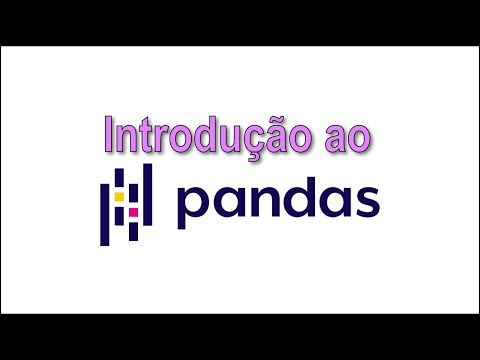

In [ ]:
YouTubeVideo('usmbTUx9zdY', start=1519)

In [ ]:
# Calcule a quantidade de clientes que usaremos
# para treinamento. Essa quantidade deve ser 90%
# do total de clientes na variável customers.
# Transforme o resultado em um número inteiro.
# O resultado deve ser gravado na variável de
# nome train_size.
train_size = int(len(customers)*0.9)
# SEU CÓDIGO AQUI!

# Use o slicing do Python para separar
# os consumidores em duas listas: uma para
# treinamento e a outra para validação. Para
# definir o ponto de corte do slicing, use
# a variável train_size definida acima. A lista
# de consumidores para treinamento deve se
# chamar customers_train e incluir exatamente
# o trecho da lista customers começando
# do início, com quantidade igual a train_size.
# Os demais devem itens ser colocados na lista
# de nome customers_val (lista ids de validação)
customers_train = customers[:train_size]
customers_test = customers[train_size:]
# SEU CÓDIGO AQUI!

# Agora, baseado nos ids separados nas listas
# customers_train e customers_val acima, crie
# dois datasets a partir do dataset original df,
# selecionando em df_train as linhas que contem
# ids da lista customers_train no campo CustomerID,
# e em df_val as linhas que contem  ids da lista
# customers_val.
df_train = df[df['CustomerID'].isin(customers_train)]
df_test= df[df['CustomerID'].isin(customers_test)]
# SEU CÓDIGO AQUI!

### Passo 4.4: Função que compila sequência de compras de cada cliente.

Com essas listas de clientes criamos abaixo as sequências de compras de acordo com os históricos de cada cliente.

In [ ]:
def compile_orders(customers, df):
  ''' Essa função coleta todas compras do histórico
      de cada cliente. O parâmetro customers é a lista
      de ids de clientes e o parâmetro df é o objeto
      DataFrame do pandas com os dados de cada compra.
      O valor retornado é uma lista de listas, onde cada
      lista interna contém a seguência de códigos de produto
      de cada compra, na ordem que se apresentava no
      histórico.
  '''

  # Essa será a lista de compras -- lista de listas de produtos
  orders = []
  
  # Coletaremos as compras de cada cliente
  for customer in customers:

    # Aqui convertemos os códigos de produtos das compras
    # de cada cliente para uma lista única
    order = df[df['CustomerID'] == customer]['StockCode'].tolist()

    # Essa lista de itens será a lista de produtos que será adicionada
    # à lista de compras principal.
    orders.append(order)
    
  return orders

In [ ]:
# Aqui separamos as listas de listas de compras. Este código
# demora cerca de 1 minuto para rodar
orders_train = compile_orders(customers_train, df_train)
orders_val = compile_orders(customers_test, df_test)

## Passo 5: Treinar o Embedding Word2Vec

Esta é a última etapa, onde utilizamos a lista de compras (lista de listas com códigos de produtos) para treinar nosso embedding. Essa lista de listas funcionará de forma análoga a uma lista de frases, onde cada frase é uma lista de palavras: lista de listas de palavras. A diferença é que aqui as strings que seriam palavras foram substituídas por códigos de produtos.

In [ ]:
# Aqui importamos o módulo GenSim
import gensim

# Importamos o NumPy
import numpy as np

# Código para ignorar warnings
# (só para 'despoluir' as saídas
#  por motivos didáticos, ignorar
#  warnings não é prática recomendada
#  exceto quando o código já foi
#  testado e os warnings examinados
#  e determinados como seguros)
import warnings;
warnings.filterwarnings('ignore')

In [ ]:
# Criamos o objeto da classe Word2Vec. Já no
# construtor passamos os parâmetros de treinamento,
# pois o modelo será treinado ao criar o objeto.

model = gensim.models.Word2Vec(orders_train, \
                               size=50, \
                               window=5, \
                               workers=10, \
                               iter=10)

In [ ]:
# Mostra os dados básicos do objeto

print(model)

Word2Vec(vocab=3181, size=50, alpha=0.025)


## Passo 5: Resultados

Finalmente podemos agora examinar como ficou o resultado.

### Passo 5.1: Produtos semelhantes

Para facilitar nossos testes, definimos abaixo uma função que retorna os 10 produtos mais semelhantes a um produto específico, passado como argumento.

In [ ]:
def most_similar(product_id):
  ''' Essa função mostra os 10 produtos mais semelhantes
      ao produto cujo código foi passado como argumento.
      Na verdade o método most_similar() do objeto Word2Vec
      já faz isso. Aqui apenas acrescentamos as descrições,
      para facilitar examinar o resultado, já que olhando
      apenas os códigos ficaria difícil de dizer se o
      conjunto de produtos semelhantes faz sentido.
  '''

  # Primeiro mostramos a descrição do produto consultado
  print('Most similar to:', products_dict[product_id])

  # Aqui buscamos a lista de códigos mais semelhantes
  # ao apresentado no embedding.
  s = model.most_similar(positive=product_id)

  # Para cada código, mostramos a descrição
  for product, prob in s:
    print(products_dict[product], prob)

In [ ]:
model.wv.index2entity[1000:1010]

['21714',
 '22653',
 '23299',
 '23340',
 '23096',
 '23376',
 '22805',
 '23374',
 '22859',
 '23053']

In [ ]:
products_dict.keys()

dict_keys(['10002', '10080', '10120', '10123C', '10124A', '10124G', '10125', '10133', '10135', '11001', '15030', '15034', '15036', '15039', '15044A', '15044B', '15044C', '15044D', '15056BL', '15056N', '15056P', '15058A', '15058B', '15058C', '15060B', '16008', '16010', '16011', '16012', '16014', '16015', '16016', '16020C', '16033', '16043', '16045', '16046', '16048', '16049', '16052', '16054', '16151A', '16156L', '16156S', '16161G', '16161M', '16161P', '16161U', '16162L', '16162M', '16168M', '16169E', '16169K', '16169M', '16169N', '16169P', '16202A', '16202B', '16202E', '16206B', '16207A', '16207B', '16216', '16218', '16219', '16225', '16235', '16236', '16237', '16238', '16244B', '16248B', '16254', '16258A', '16259', '17001', '17003', '17007B', '17011F', '17012A', '17012B', '17012C', '17012D', '17012E', '17012F', '17013D', '17014A', '17021', '17028J', '17038', '17084A', '17084J', '17084N', '17084P', '17084R', '17090A', '17090D', '17091A', '17091J', '17096', '17107D', '17109D', '17129F',

In [ ]:
# Aqui vamos verificar o produto mais semelhante
# ao produto de código 23188.

most_similar('23188')

Most similar to: ['VINTAGE  2 METRE FOLDING RULER']
['GIRAFFE WOODEN RULER'] 0.7502602934837341
['BICYCLE PUNCTURE REPAIR KIT '] 0.7451046705245972
['CLASSIC BICYCLE CLIPS '] 0.7391630411148071
['BUNDLE OF 3 SCHOOL EXERCISE BOOKS  '] 0.7165471911430359
['TRADITIONAL PICK UP STICKS GAME '] 0.7159835696220398
['REVOLVER WOODEN RULER '] 0.7125531435012817
['SNACK TRAY RED GINGHAM'] 0.7121554613113403
['TRADTIONAL ALPHABET STAMP SET'] 0.7099510431289673
['PLAYING CARDS I LOVE LONDON '] 0.7048859000205994
['BUNDLE OF 3 ALPHABET EXERCISE BOOKS'] 0.6992409825325012


## Passo 5.2: Sugestão de produtos

Agora sim, podemos fazer nosso sistema de sugestões de compras. Na variável orders_val temos os conjuntos de itens em cada compra, de cada cliente. Por exemplo, abaixo, podemos listar as compras da ordem número 32, no código abaixo:

In [ ]:
# Lista os códigos dos produtos comprados
# na ordem de compras número 32.

orders_val[32]

['84997C',
 '84997D',
 'POST',
 '84997B',
 '84997A',
 '84997D',
 '84997A',
 '84997C',
 'POST',
 '22488',
 '82578',
 '82580',
 '82581',
 '22467',
 '84997D',
 '84997C',
 '84997A',
 'POST',
 '22467',
 '84997D',
 '84997C',
 'POST',
 '84997D',
 'POST',
 '84997C',
 '84997A',
 'POST',
 'POST',
 '84997C',
 '84997A',
 '84997D',
 'POST',
 '84997D',
 'POST',
 '84997C',
 '84997D',
 '84997A',
 'POST']

Para sugerir compras, basta recuperarmos os vetores de embedding de cada um desses itens de uma ordem de compra, calcular um vetor médio (soma todos vetores e divide pela quantidade) e buscar os produtos mais semelhantes, como fizemos antes!

In [ ]:
def get_suggestions(orders):
  ''' Nesta função, passa-se como argumento uma lista
      de códigos de produtos, que representa as compras
      de um cliente, em um determinado momento. Com base
      nos embeddings desses itens, calculamos um vetor
      médio, que captura a "semântica" das compras e
      baseado nesse vetor, buscamos os produtos mais
      similares para sugerir. Apenas sugerimos os
      produtos que já não estiverem na lista.
  '''
  # Esse será o array que armazenará o embedding médio
  v = np.zeros((50))

  # Essa variável vai receber a quantidade de produtos,
  # para calcular a média mais tarde.
  count = 0

  # Aqui mostramos as descrições dos produtos já na lista
  # para facilitar a conferência.
  print('Orders so far:')
  for product in orders:
    print(products_dict[product])
    # Para cada produto no embedding (aqui testamos,
    # para evitar incluir um produto que não esteja
    # no embedding treinado, pois isso geraria um erro)
    if product in model.wv:
      # somamos o vetor de embedding daquele produto
      # no array v
      v += model.wv[product]
      # e contamos +1 em count
      count += 1
  # Dividmos o resultado por count para calcular
  # o vetor médio, no espaço de embeddings
  v /= count
  # E por fim buscamos os 10 produtos mais semelhantes
  # como fizemos originalmente.
  s = model.similar_by_vector(v)
  print('Suggestions:')
  for product, prob in s:
    # Mostramos apenas os produtos que já não estiverem
    # na lista original.
    if product not in orders:
      # Mostramos as descrições para facilitar a leitura
      print(products_dict[product], prob)

Abaixo testamos o código de sugestões definido acima.

In [ ]:
get_suggestions(orders_val[32])

Orders so far:
['CHILDRENS CUTLERY POLKADOT BLUE']
['CHILDRENS CUTLERY POLKADOT PINK']
['POSTAGE']
['CHILDRENS CUTLERY RETROSPOT RED ']
['CHILDRENS CUTLERY POLKADOT GREEN ']
['CHILDRENS CUTLERY POLKADOT PINK']
['CHILDRENS CUTLERY POLKADOT GREEN ']
['CHILDRENS CUTLERY POLKADOT BLUE']
['POSTAGE']
['NATURAL SLATE RECTANGLE CHALKBOARD']
['KITCHEN METAL SIGN']
['BATHROOM METAL SIGN']
['TOILET METAL SIGN']
['GUMBALL COAT RACK']
['CHILDRENS CUTLERY POLKADOT PINK']
['CHILDRENS CUTLERY POLKADOT BLUE']
['CHILDRENS CUTLERY POLKADOT GREEN ']
['POSTAGE']
['GUMBALL COAT RACK']
['CHILDRENS CUTLERY POLKADOT PINK']
['CHILDRENS CUTLERY POLKADOT BLUE']
['POSTAGE']
['CHILDRENS CUTLERY POLKADOT PINK']
['POSTAGE']
['CHILDRENS CUTLERY POLKADOT BLUE']
['CHILDRENS CUTLERY POLKADOT GREEN ']
['POSTAGE']
['POSTAGE']
['CHILDRENS CUTLERY POLKADOT BLUE']
['CHILDRENS CUTLERY POLKADOT GREEN ']
['CHILDRENS CUTLERY POLKADOT PINK']
['POSTAGE']
['CHILDRENS CUTLERY POLKADOT PINK']
['POSTAGE']
['CHILDRENS CUTLERY POLKADOT B

In [ ]:
get_suggestions(orders_val[67])

Orders so far:
['ANTIQUE SILVER TEA GLASS ENGRAVED']
['VINTAGE BILLBOARD LOVE/HATE MUG']
['MIRROR LOVE BIRD T-LIGHT HOLDER']
['REVOLVER WOODEN RULER ']
['BATHROOM METAL SIGN ']
['MIRROR LOVE BIRD T-LIGHT HOLDER']
['EASTER TIN CHICKS IN GARDEN']
['FOLDING UMBRELLA CHOCOLATE POLKADOT']
['SET OF 3 BIRD LIGHT PINK FEATHER ']
['PLASTERS IN TIN SPACEBOY']
['PLASTERS IN TIN SKULLS']
['PLASTERS IN TIN VINTAGE PAISLEY ']
['PLASTERS IN TIN WOODLAND ANIMALS']
['WORLD WAR 2 GLIDERS ASSTD DESIGNS']
['3 STRIPEY MICE FELTCRAFT']
['FELTCRAFT BUTTERFLY HEARTS']
['FELTCRAFT 6 FLOWER FRIENDS']
['MAKE YOUR OWN MONSOON CARD KIT']
['MAKE YOUR OWN PLAYTIME CARD KIT']
['MAKE YOUR OWN FLOWERPOWER CARD KIT']
['TOOL BOX SOFT TOY ']
['POPART WOODEN PENCILS ASST']
['CHOCOLATE CALCULATOR']
['FELTCRAFT DOLL EMILY']
['SET/6 PURPLE BUTTERFLY T-LIGHTS']
['SET/10 RED POLKADOT PARTY CANDLES']
['FELTCRAFT DOLL ROSIE']
['FELTCRAFT CUSHION RABBIT']
['FELTCRAFT BOY JEAN-PAUL KIT']
['FELTCRAFT PRINCESS CHARLOTTE DOLL']
['FELT

In [ ]:
get_suggestions(orders_val[88])

Orders so far:
['VICTORIAN GLASS HANGING T-LIGHT']
['CLASSICAL ROSE CANDLESTAND']
['BLUE STONES ON WIRE FOR CANDLE']
['JUMBO BAG RED RETROSPOT']
['SMALL GLASS HEART TRINKET POT']
['STRAWBERRY CERAMIC TRINKET POT']
['PACK OF 12 HEARTS DESIGN TISSUES ']
['NATURAL SLATE HEART CHALKBOARD ']
['GINGHAM HEART DECORATION']
['CREAM HANGING HEART T-LIGHT HOLDER']
['FENG SHUI PILLAR CANDLE']
['SET OF 6 VINTAGE NOTELETS KIT']
['PANTRY SCRUBBING BRUSH']
['LIGHT GARLAND BUTTERFILES PINK']
Suggestions:
['HANGING HEART JAR T-LIGHT HOLDER'] 0.7547391057014465
['GLASS HEART T-LIGHT HOLDER '] 0.7278977036476135
['HANGING METAL STAR LANTERN'] 0.6911719441413879
['LANTERN CREAM GAZEBO '] 0.6829525828361511
['T-LIGHT HOLDER SWEETHEART HANGING'] 0.674238383769989
['HANGING METAL HEART LANTERN'] 0.6727345585823059
['PEARL CRYSTAL PUMPKIN T-LIGHT HLDR'] 0.6700406670570374
['WHITE MOROCCAN METAL LANTERN'] 0.6683446764945984
